In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np

import suite2p

In [2]:
# Figure Style settings for notebook.
import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False,
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

# Running suite2p on example data

## Set pipeline parameters


In [3]:
ops = suite2p.default_ops()
print(ops)

{'look_one_level_down': False, 'fast_disk': [], 'delete_bin': False, 'mesoscan': False, 'bruker': False, 'h5py': [], 'h5py_key': 'data', 'save_path0': [], 'save_folder': [], 'subfolders': [], 'move_bin': False, 'nplanes': 1, 'nchannels': 1, 'functional_chan': 1, 'tau': 1.0, 'fs': 10.0, 'force_sktiff': False, 'frames_include': -1, 'multiplane_parallel': False, 'preclassify': 0.0, 'save_mat': False, 'save_NWB': False, 'combined': True, 'aspect': 1.0, 'do_bidiphase': False, 'bidiphase': 0, 'bidi_corrected': False, 'do_registration': 1, 'two_step_registration': False, 'keep_movie_raw': False, 'nimg_init': 300, 'batch_size': 500, 'maxregshift': 0.1, 'align_by_chan': 1, 'reg_tif': False, 'reg_tif_chan2': False, 'subpixel': 10, 'smooth_sigma_time': 0, 'smooth_sigma': 1.15, 'th_badframes': 1.0, 'pad_fft': False, 'nonrigid': True, 'block_size': [128, 128], 'snr_thresh': 1.2, 'maxregshiftNR': 5, '1Preg': False, 'spatial_hp': 25, 'spatial_hp_reg': 26, 'spatial_hp_detect': 25, 'pre_smooth': 2, 'sp

## Set Data Path
`Ops` and `db` are functionally equivalent internally in suite2p, with the exception that parameters provided in `db` will overwrite parameters specified in `ops`.

**Tip**:  Since it's common to change datasets and keep the same parameters for each dataset, some might find it useful to specify data-related arguments in `db` and pipeline parameters in `ops`. 

In [4]:
db = {
    'data_path': ['../data/test_data'],
    'save_path0': TemporaryDirectory().name,
    'tiff_list': ['input_1500.tif'],
}
db

{'data_path': ['../data/test_data'],
 'save_path0': 'D:\\Temp\\tmpbih3oi0t',
 'tiff_list': ['input_1500.tif']}

## Run Suite2p on Data

The `suite2p.run_s2p` function runs the pipeline and returns a list of output dictionaries containing the pipeline parameters used and extra data calculated along the way, one for each plane.

In [5]:
output_ops = suite2p.run_s2p(ops=ops, db=db)

{'data_path': ['../data/test_data'], 'save_path0': 'D:\\Temp\\tmpbih3oi0t', 'tiff_list': ['input_1500.tif']}
tif
** Found 1 tifs - converting to binary **
time 1.75 sec. Wrote 1500 tiff frames to binaries for 1 planes
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not registered / registration forced with ops['do_registration']>1
      (no previous offsets to delete)
----------- REGISTRATION
registering 1500 frames
Reference frame, 7.36 sec.
----------- Total 26.39 sec
Registration metrics, 6.47 sec.
----------- ROI DETECTION
Binning movie in chunks of length 10
Binned movie [150,252,254], 0.64 sec.
NOTE: estimated spatial scale ~12 pixels, time epochs 1.00, threshold 10.00 
0 ROIs, score=85.03
Found 300 ROIs, 3.37 sec
After removing overlaps, 296 ROIs remain
Masks made in 4.62 sec.
----------- Total 8.78 sec.
----------- EXTRACTION
Extracted fluorescence from 296 ROIs in 1500 frames, 1.60 sec.
added enhanced mean image
----------- Total 3.57 sec.
----------- CLASSIFICATION

### Outputs from the Suite2p Pipeline

#### Ops dictionaries

run_s2p() returns one ops dictionary for each plane processed.

In [6]:
len(output_ops)

1

The ops dictionary contains all the keys that went into the analysis, plus new keys that contain additional metrics calculated during the pipeline run.

In [7]:
output_op = output_ops[0]
print(set(output_op.keys()).difference(ops.keys()))

{'Lxc', 'Vmap', 'spatscale_pix', 'xblock', 'yblock', 'Ly', 'frames_per_file', 'input_format', 'corrXY1', 'Vmax', 'yoff1', 'Lyc', 'regPC', 'xrange', 'ihop', 'save_path', 'date_proc', 'meanImgE', 'data_path', 'corrXY', 'nframes', 'xoff', 'yrange', 'Vsplit', 'reg_file', 'first_tiffs', 'regDX', 'Lx', 'Vcorr', 'ops_path', 'max_proj', 'xoff1', 'refImg', 'tiff_list', 'tPC', 'badframes', 'meanImg', 'frames_per_folder', 'yoff', 'NRsm', 'nblocks', 'filelist'}


#### Results Files

In [8]:
list(Path(output_op['save_path']).iterdir())

[WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/data.bin'),
 WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/F.npy'),
 WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/Fneu.npy'),
 WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/iscell.npy'),
 WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/ops.npy'),
 WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/spks.npy'),
 WindowsPath('D:/Temp/tmpbih3oi0t/suite2p/plane0/stat.npy')]

The output parameters can also be found in the "ops.npy" file.  This is especially useful when running the pipeline from the terminal or the graphical interface.  It contains the same data that is output from the python `run_s2p()` function.

In [31]:
output_op_file = np.load(Path(output_op['save_path']).joinpath('ops.npy'), allow_pickle=True).item()
output_op_file.keys() == output_op.keys()

True

The other files will be used for the visualizations below.

## Visualizations

### Registration

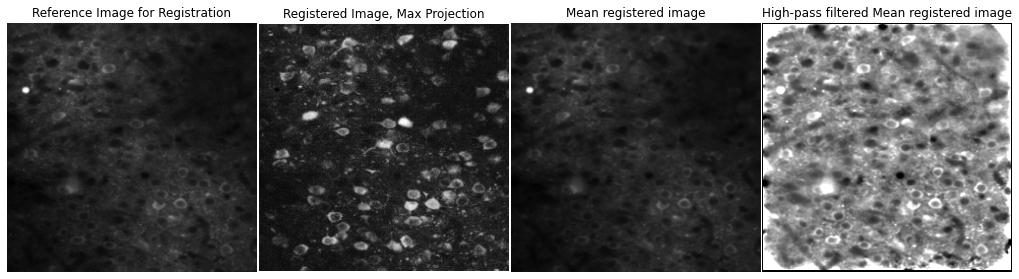

In [9]:
plt.subplot(1, 4, 1)
plt.imshow(output_op['refImg'], cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(output_op['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection");

plt.subplot(1, 4, 3)
plt.imshow(output_op['meanImg'], cmap='gray')
plt.title("Mean registered image")

plt.subplot(1, 4, 4)
plt.imshow(output_op['meanImgE'], cmap='gray')
plt.title("High-pass filtered Mean registered image");

### Detection


In [10]:
stats_file = Path(output_op['save_path']).joinpath('stat.npy')
iscell = np.load(Path(output_op['save_path']).joinpath('iscell.npy'), allow_pickle=True)[:, 0].astype(bool)
stats = np.load(stats_file, allow_pickle=True)
stats.shape, iscell.shape

((296,), (296,))

D:\miniconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':
D:\miniconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: All-NaN slice encountered
  del sys.path[0]
D:\miniconda3\envs\suite2p\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered


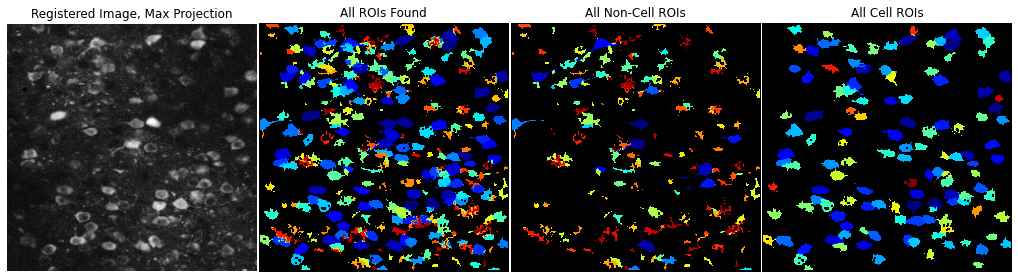

In [11]:
im = suite2p.ROI.stats_dicts_to_3d_array(stats, Ly=output_op['Ly'], Lx=output_op['Lx'], label_id=True)
im[im == 0] = np.nan

plt.subplot(1, 4, 1)
plt.imshow(output_op['max_proj'], cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 2)
plt.imshow(np.nanmax(im, axis=0), cmap='jet')
plt.title("All ROIs Found")

plt.subplot(1, 4, 3)
plt.imshow(np.nanmax(im[~iscell], axis=0, ), cmap='jet')
plt.title("All Non-Cell ROIs")

plt.subplot(1, 4, 4)
plt.imshow(np.nanmax(im[iscell], axis=0), cmap='jet')
plt.title("All Cell ROIs");


## Extract Traces


In [12]:
f_cells = np.load(Path(output_op['save_path']).joinpath('F.npy'))
f_neuropils = np.load(Path(output_op['save_path']).joinpath('Fneu.npy'))
f_cells.shape, f_neuropils.shape

((296, 1500), (296, 1500))

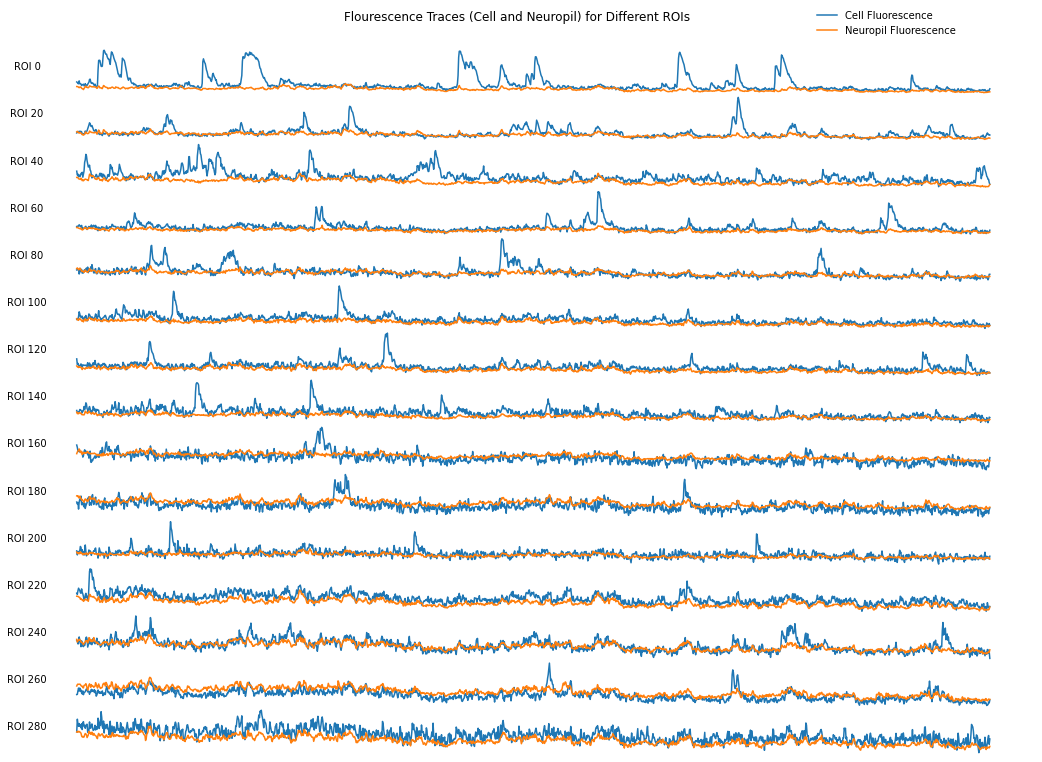

In [13]:
plt.suptitle("Flourescence Traces (Cell and Neuropil) for Different ROIs", y=0.92);

rois = np.arange(len(f_cells))[::20]
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    plt.plot(f_cells[roi], label="Cell Fluorescence")
    plt.plot(f_neuropils[roi], label="Neuropil Fluorescence")
    plt.ylabel(f"ROI {roi}", rotation=0)
    if i == 0:
        plt.legend(bbox_to_anchor=(0.93, 2))

### Spike Deconvolution

In [14]:
spks = np.load(Path(output_op['save_path']).joinpath('spks.npy'))
spks.shape

(296, 1500)

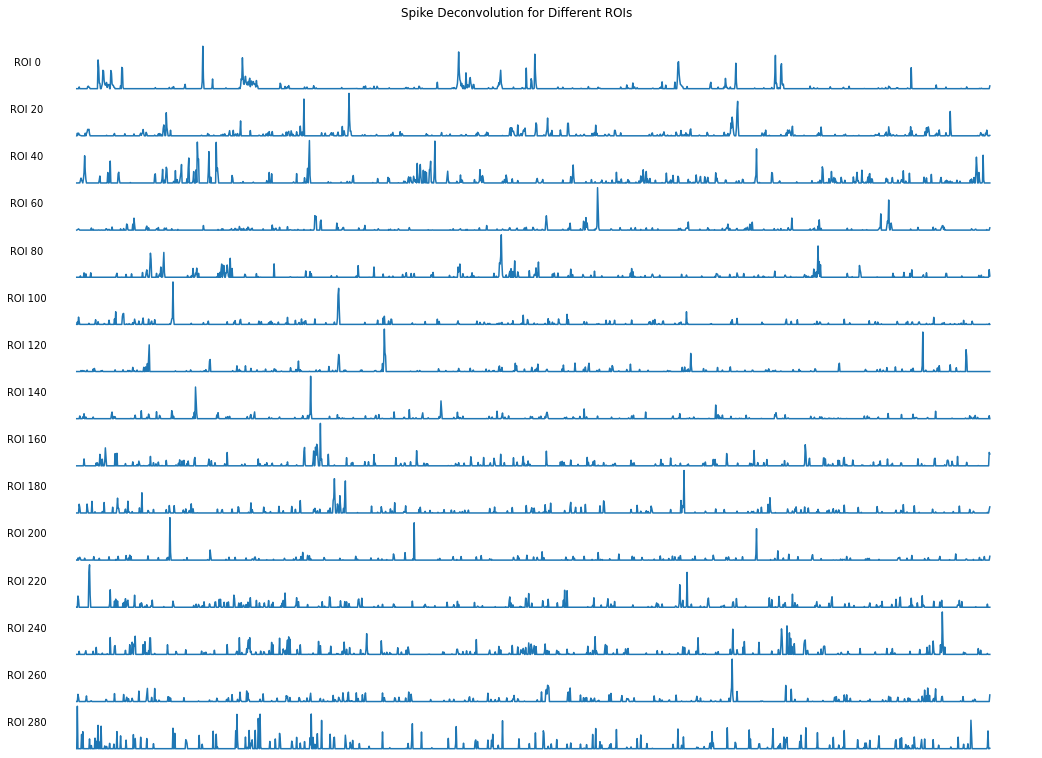

In [15]:
plt.suptitle("Spike Deconvolution for Different ROIs", y=0.92);
for i, roi in enumerate(rois):
    plt.subplot(len(rois), 1, i+1, )
    plt.plot(spks[roi])
    plt.ylabel(f"ROI {roi}", rotation=0)
